loaded
params
plot
plot


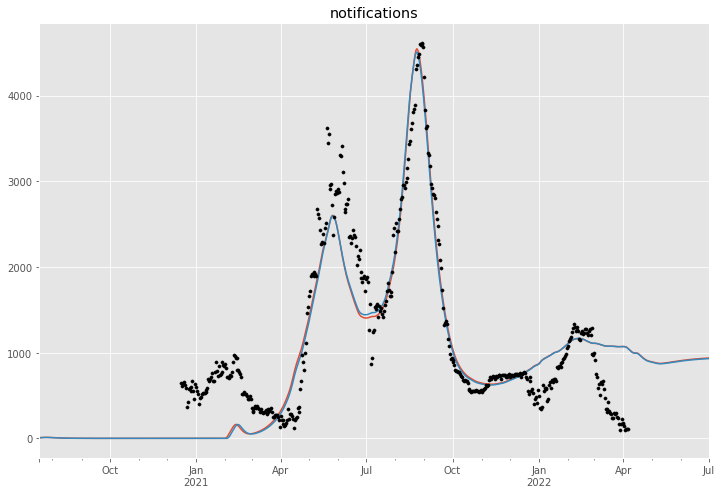

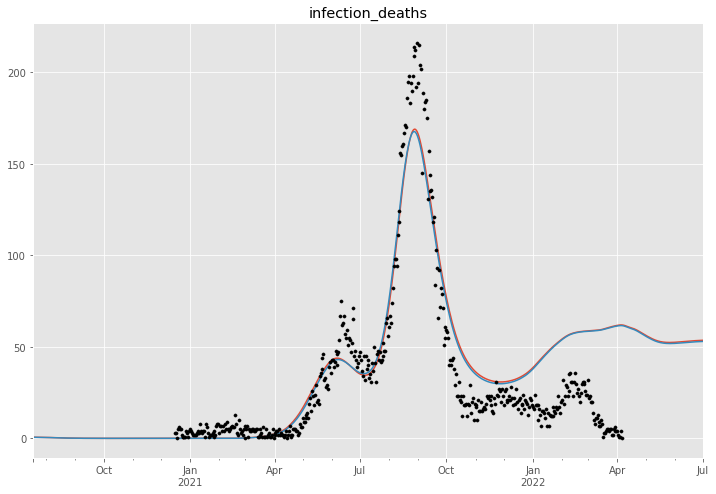

In [1]:
# import sys
# sys.path.append('../src')
# sys.path.append('/home/fgeremie/pySBO-main')
# sys.path.append('AuTuMN')

# import os
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['NUMEXPR_NUM_THREADS']= '1'
# os.environ['OMP_NUM_THREADS']= '1'
# os.environ['VECLIB_MAXIMUM_THREADS'] = '1'

from autumn.tools.project import get_project
from autumn.settings import Region, Models
from matplotlib import pyplot
from autumn.tools.plots.utils import REF_DATE
import pandas as pd
from autumn.tools.plots.uncertainty.plots import _get_target_values, _plot_targets_to_axis
import random

# load project
project = get_project(Models.COVID_19, Region.SRI_LANKA)
print("loaded")

# define params
default_params = {
    #  list all the calibrated parameters here
    'notifications_dispersion_param': 353.42633928571433, 'infection_deaths_dispersion_param': 16.875, 'contact_rate': 0.025500000000000002, 'infectious_seed': 362.5, 'testing_to_detection.assumed_cdr_parameter': 0.017, 'infection_fatality.multiplier': 0.11, 'voc_emergence.alpha_beta.start_time': 390.0, 'voc_emergence.alpha_beta.contact_rate_multiplier': 3.85, 'voc_emergence.delta.start_time': 502.5, 'voc_emergence.delta.contact_rate_multiplier': 10.0
}

keys_param = list(default_params.keys())

mean_coef_50_basic_PSO = [5.51901086e+02, 2.64904073e+01, 2.53930525e-02, 3.82734004e+02, 1.74529059e-02, 9.67592310e-02, 3.96593669e+02, 3.88666742e+00, 5.00641669e+02, 9.56123670e+00]
mean_coef_50_surrogate_PSO = [5.57921276e+02, 2.67835038e+01, 2.53231040e-02, 3.54075517e+02, 1.74048899e-02, 9.59643676e-02, 3.98741076e+02, 3.93369331e+00, 5.00070950e+02, 9.53927676e+00]


basic_PSO_params = dict(zip(keys_param, mean_coef_50_basic_PSO))
surrogate_PSO_params = dict(zip(keys_param, mean_coef_50_surrogate_PSO))

params_basic = project.param_set.baseline.update(basic_PSO_params, calibration_format=True)
params_surrogate = project.param_set.baseline.update(surrogate_PSO_params, calibration_format=True)
print("params")

# run the model
model_basic = project.run_baseline_model(params_basic)
derived_df_basic = model_basic.get_derived_outputs_df()

model_surrogate = project.run_baseline_model(params_surrogate)
derived_df_surrogate = model_surrogate.get_derived_outputs_df()



# plot the model outputs and the data used as calibration targets
target_t_min, target_t_max = project.calibration.targets[1].data.index.min(), project.calibration.targets[1].data.index.max()
pyplot.style.use("ggplot")


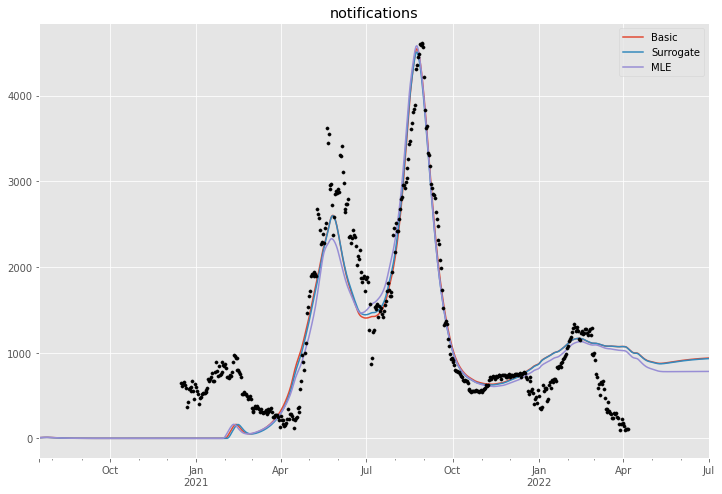

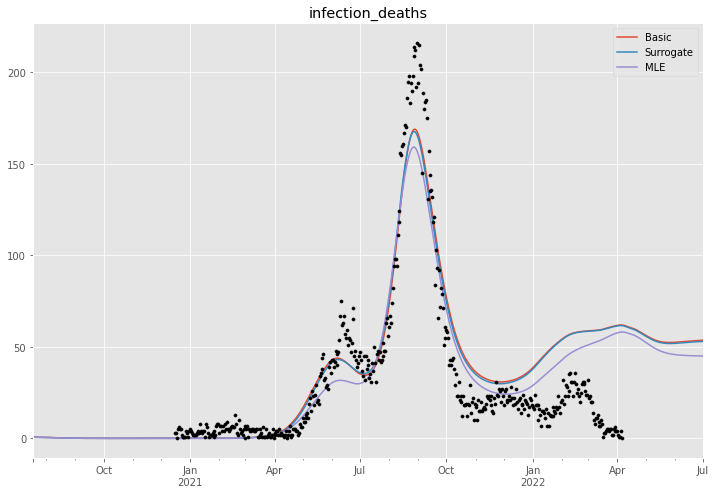

In [5]:

for output in ["notifications", "infection_deaths"]:    
    fig = pyplot.figure(figsize=(12, 8))
    axis = fig.add_subplot()

    # plot outputs
    axis = derived_df_basic[output].plot(label='Basic')
    axis2 = derived_df_surrogate[output].plot(label='Surrogate')
    axis3 = derived_df_mle[output].plot(label='MLE')
    axis.set_title(output)

    # Plot calibration targets
    values, times = _get_target_values(project.plots, output)
    values, times = zip(*[(v, t) for (v, t) in zip(values, times) if target_t_min <= t <= target_t_max])    
    date_times = pd.to_datetime(times, origin="01Jan2020",unit="D") 

    _plot_targets_to_axis(axis, values, date_times, on_uncertainty_plot=True)

    axis.legend()

    # print("plot")
    # if output == "notifications":
    #     pyplot.savefig('random_notifications_Basic_PSO.png',bbox_inches='tight', dpi=250)
    # elif output == "infection_deaths":
    #     pyplot.savefig('random_infection_deaths_Basic_PSO.png',bbox_inches='tight', dpi=250)
    # else:
    #     print("Erreur")

In [2]:
mle_params = {'notifications_dispersion_param': 565.3348502885211, 'infection_deaths_dispersion_param': 27.0, 'contact_rate': 0.024044105384736073, 'infectious_seed': 394.7091072745469, 'testing_to_detection.assumed_cdr_parameter': 0.020909402843564427, 'infection_fatality.multiplier': 0.09000960172590958, 'voc_emergence.alpha_beta.start_time': 394.23717286467433, 'voc_emergence.alpha_beta.contact_rate_multiplier': 3.92049422713674, 'voc_emergence.delta.start_time': 491.72818262629244, 'voc_emergence.delta.contact_rate_multiplier': 8.565176300387948}
params = project.param_set.baseline.update(mle_params, calibration_format=True)

mle_model = project.run_baseline_model(params)
derived_df_mle = mle_model.get_derived_outputs_df()


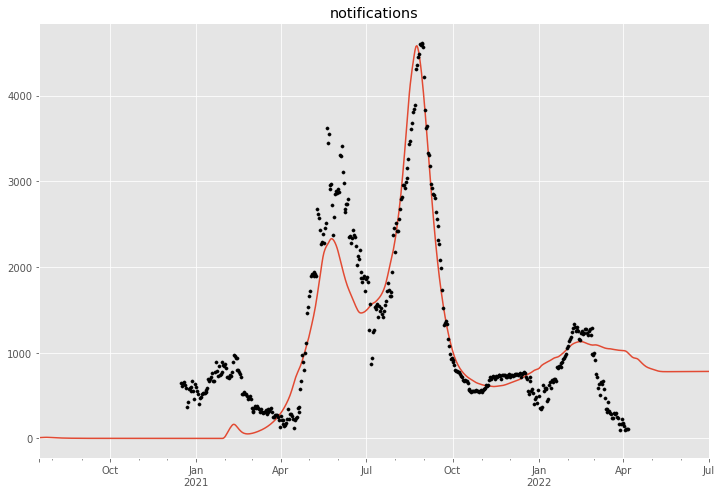

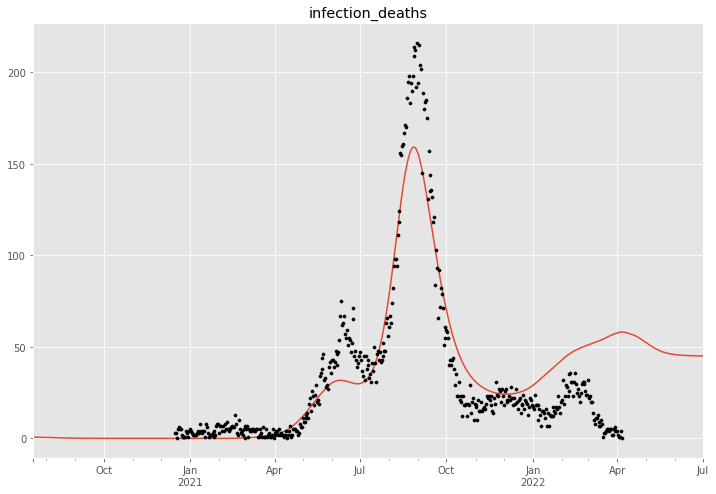

In [4]:
for output in ["notifications", "infection_deaths"]:    
    fig = pyplot.figure(figsize=(12, 8))
    axis = fig.add_subplot()

    # plot outputs
    axis = derived_df_mle[output].plot(label='MLE')
    axis.set_title(output)

    # Plot calibration targets
    values, times = _get_target_values(project.plots, output)
    values, times = zip(*[(v, t) for (v, t) in zip(values, times) if target_t_min <= t <= target_t_max])    
    date_times = pd.to_datetime(times, origin="01Jan2020",unit="D") 

    _plot_targets_to_axis(axis, values, date_times, on_uncertainty_plot=True)

In [10]:
for par, val in mle_params.items():
    prior = [p for p in project.calibration.all_priors if p['param_name'] == par][0]
    print(prior['distri_params'])
    print(f"{par}: {val}")
    print()


[141.37053571428572, 565.4821428571429]
notifications_dispersion_param: 565.3348502885211

[6.75, 27.0]
infection_deaths_dispersion_param: 27.0

[0.024, 0.027]
contact_rate: 0.024044105384736073

[275.0, 450.0]
infectious_seed: 394.7091072745469

[0.009, 0.025]
testing_to_detection.assumed_cdr_parameter: 0.020909402843564427

[0.09, 0.13]
infection_fatality.multiplier: 0.09000960172590958

[370, 410]
voc_emergence.alpha_beta.start_time: 394.23717286467433

[3.2, 4.5]
voc_emergence.alpha_beta.contact_rate_multiplier: 3.92049422713674

[475, 530]
voc_emergence.delta.start_time: 491.72818262629244

[8.5, 11.5]
voc_emergence.delta.contact_rate_multiplier: 8.565176300387948

